<td>
  <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/music_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td>

# Setup

In [1]:
!git clone https://github.com/hdperezn/MIDI_functions.git

Cloning into 'MIDI_functions'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 71 (delta 9), reused 56 (delta 3), pack-reused 0
Unpacking objects: 100% (71/71), 77.25 KiB | 1.23 MiB/s, done.


In [2]:
!sudo apt install -y fluidsynth
!pip install --upgrade pyfluidsynth

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs timidity jackd musescore
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libfluidsynth2 libinstpatch-1.0-2 qsynth
  timgm6mb-soundfont
0 upgraded, 6 newly installed, 0 to remove and 19 not upgraded.
Need to get 126 MB of archives.
After this operation, 157 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 libinstpatch-1.0-2 amd64 1.1.2-2build1 [238 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 timgm6mb-soundfont all 1.3-3 [5,420 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal/universe amd64 libfluidsynth2 amd64 2.1.1-2 [

In [3]:
!pip install pretty_midi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 42.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 KB 5.9 MB/s eta 0:00:00
  Created wheel for pretty_midi: filename=pretty_midi-0.2.9-py3-none-any.whl size=5591954 sha256=997e423d76f22b79d923ad3d1bbd07dbb45ac24979ba15cbb41a0ff16c7d45ba
  Stored in directory: /root/.cache/pip/wheels/2a/5a/e3/30eeb9a99350f3f7e21258fcb132743eef1a4f49b3505e76b6
Successfully built pretty_midi


In [4]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf

from IPython import display
from matplotlib import pyplot as plt
from MIDI_functions.MIDI_functions import *
from typing import Dict, List, Optional, Sequence, Tuple

# MIDI to pianoroll functions

In [5]:
# Sampling rate for audio playback
_SAMPLING_RATE = 16000
# dataset path
path_midi = '/content/MIDI_functions/deap_midis'
data_dir = pathlib.Path(path_midi)
filenames = glob.glob(str(data_dir/'*.mid*'))
print('Number of files:', len(filenames))

Number of files: 40


## Process a MIDI file

In [6]:
sample_file = filenames[1]
print(sample_file)

/content/MIDI_functions/deap_midis/exp_id_13_tempo24.mid


In [7]:
# creating pretty midi object 
pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm, _SAMPLING_RATE)

In [8]:
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

Number of instruments: 1
Instrument name: Electric Piano 1


## Extract notes

In [10]:
for i, note in enumerate(instrument.notes[:10]):
  note_name = pretty_midi.note_number_to_name(note.pitch)
  duration = note.end - note.start
  print(f'{i}: pitch={note.pitch}, note_name={note_name},'
        f' duration={duration:.4f}')

0: pitch=57, note_name=A3, duration=0.2448
1: pitch=45, note_name=A2, duration=0.3229
2: pitch=64, note_name=E4, duration=0.4062
3: pitch=61, note_name=C#4, duration=0.4062
4: pitch=45, note_name=A2, duration=0.4062
5: pitch=71, note_name=B4, duration=0.2188
6: pitch=61, note_name=C#4, duration=0.6719
7: pitch=64, note_name=E4, duration=0.8594
8: pitch=66, note_name=F#4, duration=0.1719
9: pitch=59, note_name=B3, duration=0.1979


In [11]:
raw_notes = midi_to_notes(sample_file)
raw_notes.head()

,pitch,start,end,step,duration
0,64,0.000000,0.406250,0.000000,0.406250
1,61,0.000000,0.406250,0.000000,0.406250
2,45,0.067708,0.390625,0.067708,0.322917
3,57,0.093750,0.338542,0.026042,0.244792
4,45,0.395833,0.802083,0.302083,0.406250


In [12]:
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

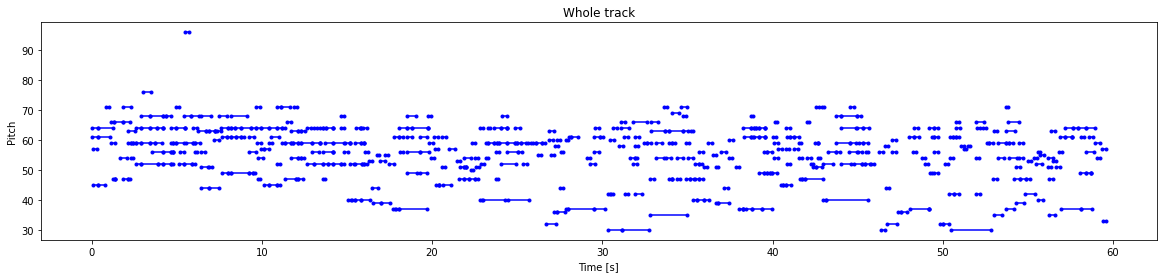

In [13]:
plot_piano_roll(raw_notes)#, #count=100)

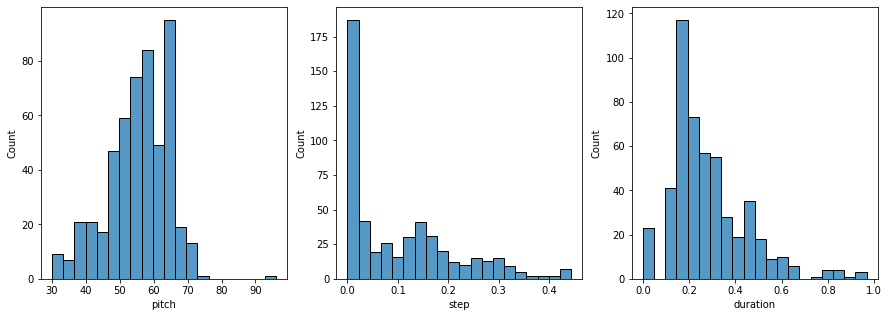

In [14]:
plot_distributions(raw_notes)